Импортируем все библиотеки

In [1]:
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
import missingno as msno
import numpy as np
from datetime import datetime, timedelta

Загружаем датасет из csv-файла

In [2]:
df = pd.read_csv('train.csv')
df.head()

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",ID_y,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,0,0,0,0,0,0,0,0,Курит,15.0,20.0,0,NaN,употребляю в настоящее время,18.0,22:00:00,06:00:00,0,0,0,54-102-358-02,0,0,0,0,0
1,54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,1,0,0,0,0,0,0,1,0,1,Никогда не курил(а),NaN,NaN,0,NaN,никогда не употреблял,NaN,00:00:00,04:00:00,1,0,0,54-103-101-01,1,1,0,0,0
2,54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,1,1-2 раза в неделю,употребляю в настоящее время,17.0,23:00:00,07:00:00,0,0,0,54-501-026-03,0,0,0,0,0
3,54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,1,0,0,0,0,1,0,0,Бросил(а),12.0,10.0,1,3-6 раз в неделю,употребляю в настоящее время,13.0,23:00:00,07:00:00,0,0,0,54-501-094-02,1,0,0,0,0
4,54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,1,1,1,0,0,0,0,0,1,0,1,Никогда не курил(а),NaN,NaN,1,не менее 1 раза в день,употребляю в настоящее время,16.0,23:00:00,06:00:00,0,0,0,54-503-022-01,1,0,1,1,0


# Почистим данные

Посмотрим, сколько у нас объектов и сколько фичей

In [3]:
print(f'В датасете {df.shape[0]} пациентов и {df.shape[1]} фичей')

В датасете 955 пациентов и 39 фичей


Проверим на пропущенные данные

<AxesSubplot:>

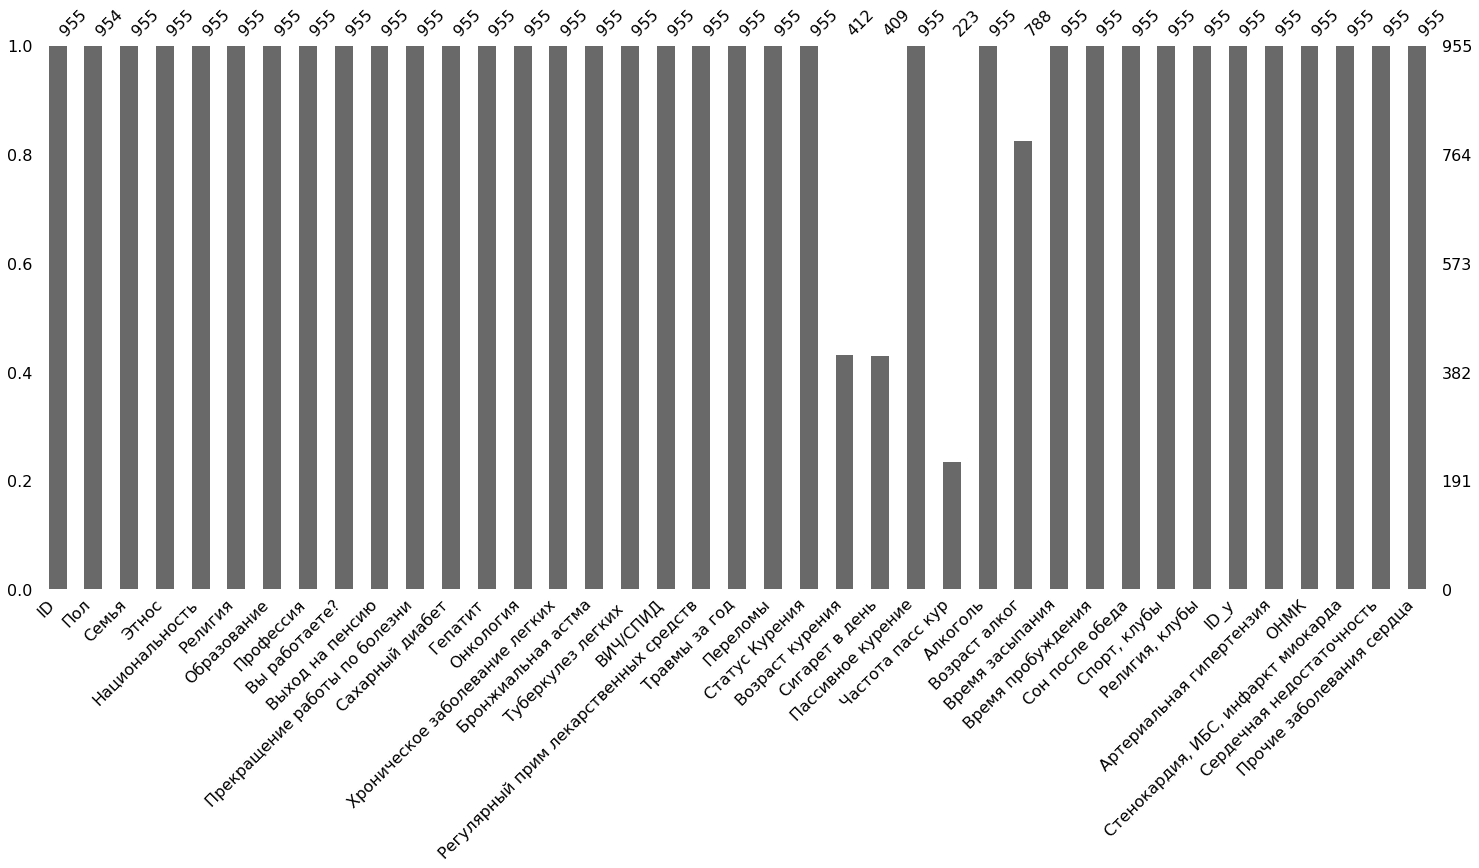

In [4]:
msno.bar(df)

Как мы видим, статус курения указан для всех пациентов. При этом возраст курения указан только для 412 человек. Проверим, соответствует ли это количеству курящих.

In [5]:
df['Статус Курения'].value_counts()

Никогда не курил(а)    543
Курит                  221
Бросил(а)              191
Name: Статус Курения, dtype: int64

221 + 191 = 412. Все правильно. При этом количество сигарет в день указано только для 409 человек. Похоже трое не стали указывать этот параметр. Проверим это

In [6]:
df[(df['Статус Курения'] != 'Никогда не курил(а)') & (df['Сигарет в день'].isna())]\
[['ID', 'Статус Курения', 'Возраст курения', 'Сигарет в день']]

,ID,Статус Курения,Возраст курения,Сигарет в день
123,54-102-244-02,Бросил(а),18.0,NaN
354,54-601-015-02,Курит,25.0,NaN
886,54-602-038-01,Курит,52.0,NaN


Создадим пока резервный датафрейм, куда помести этих троих, убрав их из основного датасета. В дальнейшем, если мы посчитаем, что влияние количества выкуренных сигарет в день на целевые признаки незначительно по сравнению с другими фичами, мы, возможно, вернем этих пациентов в датасет.

In [7]:
reserve_df = df[df['ID'].isin(['54-102-244-02', '54-601-015-02', '54-602-038-01'])]
df = df[(df['ID'].isin(['54-102-244-02', '54-601-015-02', '54-602-038-01'])) == False]
df.shape

(952, 39)

Аналогично проверим соответствие количества пассивно курящих и количества указавших частоту пассивного курения.

In [8]:
df['Пассивное курение'].value_counts()

0    728
1    224
Name: Пассивное курение, dtype: int64

Пассивно курят 224 человека, а частоту указали 223. Посмотрим, кто не указал.

In [9]:
df[(df['Пассивное курение'] == 1) & (df['Частота пасс кур'].isna())]\
[['ID', 'Пассивное курение', 'Частота пасс кур']]

,ID,Пассивное курение,Частота пасс кур
175,54-102-340-01,1,NaN
247,54-701-024-02,1,NaN


Оказывается, частоту курения не указали двое из 224 пассивно курящих. Значит еще один человек дал неверные сведения - что он не курит пассивно, но при этом указал частоту. Проверим.

In [10]:
df[(df['Пассивное курение'] == 0) & (df['Частота пасс кур'].isna() == False)]\
[['ID', 'Пассивное курение', 'Частота пасс кур']]

,ID,Пассивное курение,Частота пасс кур
392,54-001-079-01,0,3-6 раз в неделю


Этого пациента смело удаляем из данных, а первых двух - в резерв.

In [11]:
reserve_df = pd.merge(reserve_df, df[df['ID'].isin(['54-102-340-01', '54-701-024-02'])], how = 'outer')
df = df[(df['ID'].isin(['54-102-340-01', '54-701-024-02', '54-001-079-01'])) == False]
df.shape

/home/michael/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


(949, 39)

Осталось разобраться с алкоголиками

In [12]:
df['Алкоголь'].value_counts()

употребляю в настоящее время    630
никогда не употреблял           165
ранее употреблял                154
Name: Алкоголь, dtype: int64

634 + 156 = 790 человек употребляют или употребляли алкоголь, а длительность периода приема указали 788. Проверим это соответствие.

In [13]:
df[(df['Алкоголь'] != 'никогда не употреблял') & (df['Возраст алког'].isna())]\
[['ID', 'Алкоголь', 'Возраст алког']]

,ID,Алкоголь,Возраст алког
451,54-102-238-02,употребляю в настоящее время,NaN
545,54-701-032-01,употребляю в настоящее время,NaN


Действительно, двое из пьющих не указали период приема алкоголя. Убираем их из основного датафрейма в резервный.

In [14]:
reserve_df = pd.merge(reserve_df, df[df['ID'].isin(['54-102-238-02', '54-701-032-01'])], how = 'outer')
df = df[(df['ID'].isin(['54-102-238-02', '54-701-032-01'])) == False]
df.shape

/home/michael/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


(947, 39)

Также в столбце "Пол" отсутствует одно значение.

In [15]:
df[df['Пол'].isin(['М', 'Ж']) == False]

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",ID_y,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
304,54-701-009-01,NaN,гражданский брак / проживание с партнером,европейская,Русские,Нет,3 - средняя школа / закон.среднее / выше среднего,"работники, занятые в сфере обслуживания, торг...",1,0,0,0,0,0,0,0,0,0,0,0,0,Курит,18.0,3.0,0,NaN,употребляю в настоящее время,20.0,01:00:00,06:30:00,0,0,0,54-701-009-01,0,0,0,0,0


Перенесем и этого пациента в резерв

In [16]:
reserve_df = pd.merge(reserve_df, df[df['ID'] == '54-701-009-01'], how = 'outer')
df = df[df['ID'] != '54-701-009-01']
df.shape

/home/michael/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


(946, 39)

Проверим, одинаковы ли значения в столбцах 'ID' и 'ID_y'

In [17]:
df[df[['ID','ID_y']].nunique(axis=1) == 0].shape

(0, 39)

Эти столбцы абсолютно идентичны. Удалим 'ID_y', а 'ID' сделаем индексом

In [18]:
df = df.drop(['ID_y'], axis = 1)
df = df.set_index('ID')

Проверим типы столбцов

In [19]:
df.dtypes

Пол                                       object
Семья                                     object
Этнос                                     object
Национальность                            object
Религия                                   object
Образование                               object
Профессия                                 object
Вы работаете?                              int64
Выход на пенсию                            int64
Прекращение работы по болезни              int64
Сахарный диабет                            int64
Гепатит                                    int64
Онкология                                  int64
Хроническое заболевание легких             int64
Бронжиальная астма                         int64
Туберкулез легких                          int64
ВИЧ/СПИД                                   int64
Регулярный прим лекарственных средств      int64
Травмы за год                              int64
Переломы                                   int64
Статус Курения      

Приведем столбцы "Время засыпания" и "Время пробуждения" к типу даты и времени.

In [20]:
df[['Время засыпания', 'Время пробуждения']] = df[['Время засыпания', 'Время пробуждения']].astype('datetime64')
df[['Время засыпания', 'Время пробуждения']].dtypes

Время засыпания      datetime64[ns]
Время пробуждения    datetime64[ns]
dtype: object

Введём новый столбец - "Время сна". Он тоже может влиять на целевые показатели

In [21]:
df['Время сна'] = df['Время пробуждения'] - df['Время засыпания']

In [22]:
def sleep_time(x):
    x = int(x.total_seconds()) // 3600
    if x < 0:
        x += 24
    return x
df['Время сна'] = df['Время сна'].apply(lambda x: sleep_time(x))

Проверим достоверность полученных данных

In [23]:
df['Время сна'].value_counts()

7     284
8     249
9     138
6     132
10     62
5      39
11     15
4      14
12      6
3       3
13      2
19      1
0       1
Name: Время сна, dtype: int64

Так как время засыпания и пробуждения пациенты указывали в среднем для определенного периода, а не для одного какого-то дня, то показатель времени сна в 19 часов каждый день явно неправдоподобен. Такой пациент один. Давайте лучше удалим его, чтобы он не вносил погрешность в наши исследования.

In [24]:
df[df['Время сна'] == 19][['Время засыпания', 'Время пробуждения']]

,Время засыпания,Время пробуждения
ID,,
54-002-054-02,2022-06-16 12:00:00,2022-06-16 07:00:00


Действительно маловероятно засыпать в 12 и просыпаться в 7 каждый день. Удаляем.

In [25]:
df = df[df['Время сна'] != 19]

Три столбца имеют тип float, хотя по сути это целые числа. Это связано с наличием NaN-значений. В данном случае их все можно заменить нулями, и привести столбцы к типу int.

In [26]:
df = df.fillna(0)
df[['Возраст курения', 'Сигарет в день', 'Возраст алког']] =\
df[['Возраст курения', 'Сигарет в день', 'Возраст алког']].astype('int64')

Посмотрим некоторые статистические данные по числовым и категориальным признакам.

In [28]:
df.describe(include=[np.number])

,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Возраст курения,Сигарет в день,Пассивное курение,Возраст алког,Сон после обеда,"Спорт, клубы","Религия, клубы",Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца,Время сна
count,945.000000,945.000000,945.000000,945.00000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,0.524868,0.336508,0.046561,0.10582,0.119577,0.044444,0.076190,0.043386,0.021164,0.002116,0.644444,0.053968,0.353439,8.658201,6.113228,0.234921,16.532275,0.225397,0.068783,0.023280,0.465608,0.042328,0.123810,0.101587,0.089947,7.573545
std,0.499646,0.472765,0.210808,0.30777,0.324638,0.206190,0.265443,0.203833,0.144007,0.045980,0.478935,0.226075,0.478291,11.290961,9.713092,0.424174,8.951568,0.418065,0.253219,0.150873,0.499080,0.201443,0.329539,0.302265,0.286257,1.463228
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,18.000000,10.000000,0.000000,20.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,58.000000,60.000000,1.000000,63.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000


In [29]:
df.describe(include=[object])

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Статус Курения,Частота пасс кур,Алкоголь
count,945,945,945,945,945,945,945,945,945,945
unique,2,6,3,18,4,4,11,3,6,3
top,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,дипломированные специалисты,Никогда не курил(а),0,употребляю в настоящее время
freq,664,556,922,890,797,451,224,541,723,627


Посмотрим на все возможные значения строковых столбцов

In [30]:
for col in list(df.describe(include=[object]).columns):
    print(f'Значения столбца "{col}": ', end = '')
    for i, elem in enumerate(df[col].unique()):
        if (i == len(df[col].unique()) - 1):
            print(elem)
        else:
            print(elem, end = ', ')
    print(100 * '-')

Значения столбца "Пол": М, Ж
----------------------------------------------------------------------------------------------------
Значения столбца "Семья": в браке в настоящее время, в разводе, гражданский брак / проживание с партнером, вдовец / вдова, никогда не был(а) в браке, раздельное проживание (официально не разведены)
----------------------------------------------------------------------------------------------------
Значения столбца "Этнос": европейская, другая азиатская (Корея, Малайзия, Таиланд, Вьетнам, Казахстан, Киргизия, Туркмения, Узбекистан, Таджикистан), прочее (любая иная этно-расовая группа, не представленная выше)
----------------------------------------------------------------------------------------------------
Значения столбца "Национальность": Русские, Азербайджанцы, Татары, Немцы, Эстонцы, Другие национальности, Молдаване, Украинцы, Чуваши, Мордва, Киргизы, Казахи, Армяне, Белорусы, Таджики, Башкиры, Евреи, Буряты
----------------------------------------------

# Исследование зависимостей и формулирование гипотез

Предварительно надо ранжировать все категориальные признаки. Для этого пизнаки, имеющие две категории, закодируем с помощью метода доступа cat.codes, а признаки с числом категорий более двух - с помощью one-hot encoding.

In [31]:
print(f'В столбце "Пол":  ', end = '')
cat_col = df['Пол'].astype('category')
codes = cat_col.cat.codes
cats = cat_col.cat.categories
df.loc[:, 'Пол'] = codes
print(f'{cats[0]} --> 0,  ', end = '')
print(f'{cats[1]} --> 1.')               

В столбце "Пол":  Ж --> 0,  М --> 1.


In [32]:
df = pd.get_dummies(df)
df.head()

,Пол,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Возраст курения,Сигарет в день,Пассивное курение,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца,Время сна,Семья_в браке в настоящее время,Семья_в разводе,Семья_вдовец / вдова,Семья_гражданский брак / проживание с партнером,Семья_никогда не был(а) в браке,Семья_раздельное проживание (официально не разведены),"Этнос_другая азиатская (Корея, Малайзия, Таиланд, Вьетнам, Казахстан, Киргизия, Туркмения, Узбекистан, Таджикистан)",Этнос_европейская,"Этнос_прочее (любая иная этно-расовая группа, не представленная выше)",Национальность_Азербайджанцы,Национальность_Армяне,Национальность_Башкиры,Национальность_Белорусы,Национальность_Буряты,Национальность_Другие национальности,Национальность_Евреи,Национальность_Казахи,Национальность_Киргизы,Национальность_Молдаване,Национальность_Мордва,Национальность_Немцы,Национальность_Русские,Национальность_Таджики,Национальность_Татары,Национальность_Украинцы,Национальность_Чуваши,Национальность_Эстонцы,Религия_Атеист / агностик,Религия_Ислам,Религия_Нет,Религия_Христианство,Образование_2 - начальная школа,Образование_3 - средняя школа / закон.среднее / выше среднего,Образование_4 - профессиональное училище,Образование_5 - ВУЗ,Профессия_ведение домашнего хозяйства,Профессия_вооруженные силы,Профессия_дипломированные специалисты,Профессия_квалифицированные работники сельского хозяйства и рыболовного,Профессия_низкоквалифицированные работники,Профессия_операторы и монтажники установок и машинного оборудования,"Профессия_представители законодат. органов власти, высокопостав. долж.лица и менеджеры","Профессия_работники, занятые в сфере обслуживания, торговые работники магазинов и рынков",Профессия_ремесленники и представители других отраслей промышленности,Профессия_служащие,Профессия_техники и младшие специалисты,Статус Курения_Бросил(а),Статус Курения_Курит,Статус Курения_Никогда не курил(а),Частота пасс кур_0,Частота пасс кур_1-2 раза в неделю,Частота пасс кур_2-3 раза в день,Частота пасс кур_3-6 раз в неделю,Частота пасс кур_4 и более раз в день,Частота пасс кур_не менее 1 раза в день,Алкоголь_никогда не употреблял,Алкоголь_ранее употреблял,Алкоголь_употребляю в настоящее время
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54-102-358-02,1,1,0,0,0,0,0,0,0,0,0,0,0,0,15,20,0,18,2022-06-16 22:00:00,2022-06-16 06:00:00,0,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
54-103-101-01,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,2022-06-16 00:00:00,2022-06-16 04:00:00,1,0,0,1,1,0,0,0,4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
54-501-026-03,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,17,2022-06-16 23:00:00,2022-06-16 07:00:00,0,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
54-501-094-02,1,1,0,0,0,0,1,0,0,0,0,1,0,0,12,10,1,13,2022-06-16 23:00:00,2022-06-16 07:00:00,0,0,0,1,0,0,0,0,8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
54-503-022-01,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,1,16,2022-06-16 23:00:00,2022-06-16 06:00:00,0,0,0,1,0,1,1,0,7,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
